# softmax 和分类模型

> 本文参考：
- 伯禹AI：https://www.boyuai.com/elites/course/cZu18YmweLv10OeV
- 动手学深度学习：http://zh.d2l.ai/
- 动手学深度学习 TF 版：https://trickygo.github.io/Dive-into-DL-TensorFlow2.0


内容包含：
1. softmax回归的基本概念
2. 如何获取 Fashion-MNIST 数据集和读取数据
3. softmax回归模型的从零开始实现，实现一个对 Fashion-MNIST 训练集中的图像数据进行分类的模型
4. 使用 Tensorflow 重新实现 softmax 回归模型


## softmax 回归的基本概念

- 分类问题  
一个简单的图像分类问题，输入图像的高和宽均为2像素，色彩为灰度。  
图像中的4像素分别记为$x_1, x_2, x_3, x_4$。  
假设真实标签为狗、猫或者鸡，这些标签对应的离散值为$y_1, y_2, y_3$。  
我们通常使用离散的数值来表示类别，例如$y_1=1, y_2=2, y_3=3$。

- 权重矢量  
$$
 \begin{aligned} o_1 &= x_1 w_{11} + x_2 w_{21} + x_3 w_{31} + x_4 w_{41} + b_1 \end{aligned} 
$$

$$
 \begin{aligned} o_2 &= x_1 w_{12} + x_2 w_{22} + x_3 w_{32} + x_4 w_{42} + b_2 \end{aligned} 
$$

$$
 \begin{aligned} o_3 &= x_1 w_{13} + x_2 w_{23} + x_3 w_{33} + x_4 w_{43} + b_3 \end{aligned} 
$$

- 神经网络图  
下图用神经网络图描绘了上面的计算。softmax回归同线性回归一样，也是一个单层神经网络。由于每个输出$o_1, o_2, o_3$的计算都要依赖于所有的输入$x_1, x_2, x_3, x_4$，softmax回归的输出层也是一个全连接层。

![Image Name](../img/chapter03/3.8_mlp.svg)

$$
\begin{aligned}softmax回归是一个单层神经网络\end{aligned}
$$

既然分类问题需要得到离散的预测输出，一个简单的办法是将输出值$o_i$当作预测类别是$i$的置信度，并将值最大的输出所对应的类作为预测输出，即输出 $\underset{i}{\arg\max} o_i$。例如，如果$o_1,o_2,o_3$分别为$0.1,10,0.1$，由于$o_2$最大，那么预测类别为2，其代表猫。

- 输出问题  
直接使用输出层的输出有两个问题：
    1. 一方面，由于输出层的输出值的范围不确定，我们难以直观上判断这些值的意义。例如，刚才举的例子中的输出值10表示“很置信”图像类别为猫，因为该输出值是其他两类的输出值的100倍。但如果$o_1=o_3=10^3$，那么输出值10却又表示图像类别为猫的概率很低。
    2. 另一方面，由于真实标签是离散值，这些离散值与不确定范围的输出值之间的误差难以衡量。

softmax运算符（softmax operator）解决了以上两个问题。它通过下式将输出值变换成值为正且和为1的概率分布：

$$
 \hat{y}_1, \hat{y}_2, \hat{y}_3 = \text{softmax}(o_1, o_2, o_3) 
$$

其中

$$
 \hat{y}1 = \frac{ \exp(o_1)}{\sum_{i=1}^3 \exp(o_i)},\quad \hat{y}2 = \frac{ \exp(o_2)}{\sum_{i=1}^3 \exp(o_i)},\quad \hat{y}3 = \frac{ \exp(o_3)}{\sum_{i=1}^3 \exp(o_i)}. 
$$

容易看出$\hat{y}_1 + \hat{y}_2 + \hat{y}_3 = 1$且$0 \leq \hat{y}_1, \hat{y}_2, \hat{y}_3 \leq 1$，因此$\hat{y}_1, \hat{y}_2, \hat{y}_3$是一个合法的概率分布。这时候，如果$\hat{y}_2=0.8$，不管$\hat{y}_1$和$\hat{y}_3$的值是多少，我们都知道图像类别为猫的概率是80%。此外，我们注意到

$$
 \underset{i}{\arg\max} o_i = \underset{i}{\arg\max} \hat{y}_i 
$$

因此softmax运算不改变预测类别输出。

- 计算效率
    - 单样本矢量计算表达式  
    为了提高计算效率，我们可以将单样本分类通过矢量计算来表达。在上面的图像分类问题中，假设softmax回归的权重和偏差参数分别为
   
$$
 \boldsymbol{W} = \begin{bmatrix} w_{11} & w_{12} & w_{13} \\ w_{21} & w_{22} & w_{23} \\ w_{31} & w_{32} & w_{33} \\ w_{41} & w_{42} & w_{43} \end{bmatrix},\quad \boldsymbol{b} = \begin{bmatrix} b_1 & b_2 & b_3 \end{bmatrix}, 
$$

设高和宽分别为2个像素的图像样本$i$的特征为
   
$$
\boldsymbol{x}^{(i)} = \begin{bmatrix}x_1^{(i)} & x_2^{(i)} & x_3^{(i)} & x_4^{(i)}\end{bmatrix},
$$

输出层的输出为

$$
\boldsymbol{o}^{(i)} = \begin{bmatrix}o_1^{(i)} & o_2^{(i)} & o_3^{(i)}\end{bmatrix},
$$

预测为狗、猫或鸡的概率分布为
    
$$
\boldsymbol{\hat{y}}^{(i)} = \begin{bmatrix}\hat{y}_1^{(i)} & \hat{y}_2^{(i)} & \hat{y}_3^{(i)}\end{bmatrix}.
$$

softmax回归对样本$i$分类的矢量计算表达式为
   
$$
 \begin{aligned} \boldsymbol{o}^{(i)} &= \boldsymbol{x}^{(i)} \boldsymbol{W} + \boldsymbol{b},\\ \boldsymbol{\hat{y}}^{(i)} &= \text{softmax}(\boldsymbol{o}^{(i)}). \end{aligned} 
$$

- 小批量矢量计算表达式  
    为了进一步提升计算效率，我们通常对小批量数据做矢量计算。广义上讲，给定一个小批量样本，其批量大小为$n$，输入个数（特征数）为$d$，输出个数（类别数）为$q$。设批量特征为$\boldsymbol{X} \in \mathbb{R}^{n \times d}$。假设softmax回归的权重和偏差参数分别为$\boldsymbol{W} \in \mathbb{R}^{d \times q}$和$\boldsymbol{b} \in \mathbb{R}^{1 \times q}$。softmax回归的矢量计算表达式为

$$
 \begin{aligned} \boldsymbol{O} &= \boldsymbol{X} \boldsymbol{W} + \boldsymbol{b},\\ \boldsymbol{\hat{Y}} &= \text{softmax}(\boldsymbol{O}), \end{aligned} 
$$

其中的加法运算使用了广播机制，$\boldsymbol{O}, \boldsymbol{\hat{Y}} \in \mathbb{R}^{n \times q}$且这两个矩阵的第$i$行分别为样本$i$的输出$\boldsymbol{o}^{(i)}$和概率分布$\boldsymbol{\hat{y}}^{(i)}$。


## 交叉熵损失函数

对于样本$i$，我们构造向量$\boldsymbol{y}^{(i)}\in \mathbb{R}^{q}$ ，使其第$y^{(i)}$（样本$i$类别的离散数值）个元素为1，其余为0。这样我们的训练目标可以设为使预测概率分布$\boldsymbol{\hat y}^{(i)}$尽可能接近真实的标签概率分布$\boldsymbol{y}^{(i)}$。

- 平方损失估计  

$$
\begin{aligned}Loss = |\boldsymbol{\hat y}^{(i)}-\boldsymbol{y}^{(i)}|^2/2\end{aligned}
$$
  

然而，想要预测分类结果正确，我们其实并不需要预测概率完全等于标签概率。例如，在图像分类的例子里，如果$y^{(i)}=3$，那么我们只需要$\hat{y}^{(i)}_3$比其他两个预测值$\hat{y}^{(i)}_1$和$\hat{y}^{(i)}_2$大就行了。即使$\hat{y}^{(i)}_3$值为0.6，不管其他两个预测值为多少，类别预测均正确。而平方损失则过于严格，例如$\hat y^{(i)}_1=\hat y^{(i)}_2=0.2$比$\hat y^{(i)}_1=0, \hat y^{(i)}_2=0.4$的损失要小很多，虽然两者都有同样正确的分类预测结果。

改善上述问题的一个方法是使用更适合衡量两个概率分布差异的测量函数。其中，交叉熵（cross entropy）是一个常用的衡量方法：


$$
H\left(\boldsymbol y^{(i)}, \boldsymbol {\hat y}^{(i)}\right ) = -\sum_{j=1}^q y_j^{(i)} \log \hat y_j^{(i)},
$$


其中带下标的$y_j^{(i)}$是向量$\boldsymbol y^{(i)}$中非0即1的元素，需要注意将它与样本$i$类别的离散数值，即不带下标的$y^{(i)}$区分。在上式中，我们知道向量$\boldsymbol y^{(i)}$中只有第$y^{(i)}$个元素$y^{(i)}{y^{(i)}}$为1，其余全为0，于是$H(\boldsymbol y^{(i)}, \boldsymbol {\hat y}^{(i)}) = -\log \hat y_{y^{(i)}}^{(i)}$。也就是说，**交叉熵只关心对正确类别的预测概率**，因为只要其值足够大，就可以确保分类结果正确。当然，遇到一个样本有多个标签时，例如图像里含有不止一个物体时，我们并不能做这一步简化。但即便对于这种情况，交叉熵同样只关心对图像中出现的物体类别的预测概率。

假设训练数据集的样本数为$n$，交叉熵损失函数定义为 
$$
\ell(\boldsymbol{\Theta}) = \frac{1}{n} \sum_{i=1}^n H\left(\boldsymbol y^{(i)}, \boldsymbol {\hat y}^{(i)}\right ),
$$


其中$\boldsymbol{\Theta}$代表模型参数。同样地，如果每个样本只有一个标签，那么交叉熵损失可以简写成$\ell(\boldsymbol{\Theta}) = -(1/n) \sum_{i=1}^n \log \hat y_{y^{(i)}}^{(i)}$。从另一个角度来看，我们知道最小化$\ell(\boldsymbol{\Theta})$等价于最大化$\exp(-n\ell(\boldsymbol{\Theta}))=\prod_{i=1}^n \hat y_{y^{(i)}}^{(i)}$，即**最小化交叉熵损失函数等价于最大化训练数据集所有标签类别的联合预测概率**。


在训练好softmax回归模型后，给定任一样本特征，就可以预测每个输出类别的概率。通常，我们把预测概率最大的类别作为输出类别。如果它与真实类别（标签）一致，说明这次预测是正确的。在后续实验中，我们将使用准确率（accuracy）来评价模型的表现。它等于正确预测数量与总预测数量之比。

### 获取Fashion-MNIST训练集和读取数据
在介绍softmax回归的实现前我们先引入一个多类图像分类数据集。它将在后面的章节中被多次使用，以方便我们观察比较算法之间在模型精度和计算效率上的区别。图像分类数据集中最常用的是手写数字识别数据集MNIST[1]。但大部分模型在MNIST上的分类精度都超过了95%。为了更直观地观察算法之间的差异，我们将使用一个图像内容更加复杂的数据集Fashion-MNIST[2]。


In [2]:
# import needed package
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import time
import sys 
print(tf.__version__)

2.1.0


下面，我们通过keras的dataset包来下载这个数据集。第一次调用时会自动从网上获取数据。我们通过参数train来指定获取训练数据集或测试数据集（testing data set）。测试数据集也叫测试集（testing set），只用来评价模型的表现，并不用来训练模型。

In [1]:
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [23]:
# 训练集中和测试集中的每个类别的图像数分别为6,000和1,000, 类别数为 10
len(x_train), len(x_test)

(60000, 10000)

In [24]:
# 我们可以通过下标来访问任意一个样本
feature, label = x_train[0], y_train[0]
# 28*28 像素，每个像素的数值为0到255之间8位无符号整数（uint8）
print(feature.shape, feature.dtype, type(feature))
print(label, label.dtype, type(label))

(28, 28) uint8 <class 'numpy.ndarray'>
9 uint8 <class 'numpy.uint8'>


Fashion-MNIST中一共包括了10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。以下函数可以将数值标签转成相应的文本标签。

In [6]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [33]:
# 定义一个可以在一行里画出多张图像和对应标签的函数。
def show_fashion_mnist(images, labels):
    # 这⾥的_表示我们忽略（不使⽤）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12)) # 这里注意subplot 和subplots 的区别
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(tf.reshape(img, shape=(28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

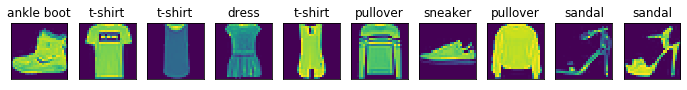

In [34]:
X, y = [], []
for i in range(10):
    X.append(x_train[i]) # 将第i个feature加到X中
    y.append(y_train[i]) # 将第i个label加到y中
show_fashion_mnist(X, get_fashion_mnist_labels(y))

读取小批量

In [10]:
bath_size = 256
if sys.platform.startswith('win'):
    num_workers = 0  # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 4
    
train_iter = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(bath_size)

In [11]:
start = time.time()
for X, y in train_iter:
    continue
print('%.2f sec' % (time.time() - start))

0.50 sec


## softmax从零开始的实现

### 获取训练集数据和测试集数据

In [3]:
from tensorflow.keras.datasets import fashion_mnist

batch_size=256
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = tf.cast(x_train, tf.float32) / 255 #在进行矩阵相乘时需要float型，故强制类型转换为float型
x_test = tf.cast(x_test,tf.float32) / 255 #在进行矩阵相乘时需要float型，故强制类型转换为float型
train_iter = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
test_iter = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

### 模型参数初始化


跟线性回归中的例子一样，我们将使用向量表示每个样本。已知每个样本输入是高和宽均为28像素的图像。模型的输入向量的长度是 $28 \times 28 = 784$：该向量的每个元素对应图像中每个像素。由于图像有10个类别，单层神经网络输出层的输出个数为10，因此softmax回归的权重和偏差参数分别为$784 \times 10$和$1 \times 10$的矩阵。`Variable`来标注需要记录梯度的向量。

In [4]:
num_inputs = 784
num_outputs = 10
W = tf.Variable(tf.random.normal(shape=(num_inputs, num_outputs),mean=0, stddev=0.01, dtype=tf.float32))
b = tf.Variable(tf.zeros(num_outputs, dtype=tf.float32))

### 对多维Tensor按维度操作

In [16]:
X = tf.constant([[1,2,3], [4,5,6]])
print(tf.reduce_sum(X, axis=0, keepdims=True))
print(tf.reduce_sum(X, axis=1, keepdims=True))

tf.Tensor([[5 7 9]], shape=(1, 3), dtype=int32)
tf.Tensor(
[[ 6]
 [15]], shape=(2, 1), dtype=int32)


In [17]:
# 不保留维度
print(tf.reduce_sum(X, axis=0))
print(tf.reduce_sum(X, axis=1))

tf.Tensor([5 7 9], shape=(3,), dtype=int32)
tf.Tensor([ 6 15], shape=(2,), dtype=int32)


### 定义softmax操作

$$
 \hat{y}_j = \frac{ \exp(o_j)}{\sum_{i=1}^3 \exp(o_i)} 
$$



In [28]:
def softmax(logits, axis=-1):
    # axis=-1 表示最后一个维度,矩阵相当于 axis=1，即计算一行元素
    logits_exp = tf.exp(logits)
    return logits_exp / tf.reduce_sum(logits_exp, axis, keepdims=True) # 这里运用广播机制

In [29]:
X = tf.random.normal(shape=(2, 5))
X_prob = softmax(X)
X_prob, tf.reduce_sum(X_prob, axis=1)

(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[0.13094425, 0.22753422, 0.1210086 , 0.08528198, 0.43523097],
        [0.3038182 , 0.14748935, 0.10095752, 0.18262233, 0.26511264]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>)

### softmax回归模型
 
$$
 \begin{aligned} \boldsymbol{o}^{(i)} &= \boldsymbol{x}^{(i)} \boldsymbol{W} + \boldsymbol{b},\\ \boldsymbol{\hat{y}}^{(i)} &= \text{softmax}(\boldsymbol{o}^{(i)}). \end{aligned} 
$$



In [35]:
def net(X):
    # 这里通过reshpe函数将每张原始图像改成长度为num_inputs的向量。X*W
    logits = tf.matmul(tf.reshape(X, shape=(-1, W.shape[0])), W) + b
    return softmax(logits)

### 定义损失函数

$$
H\left(\boldsymbol y^{(i)}, \boldsymbol {\hat y}^{(i)}\right ) = -\sum_{j=1}^q y_j^{(i)} \log \hat y_j^{(i)},
$$
  

$$
\ell(\boldsymbol{\Theta}) = \frac{1}{n} \sum_{i=1}^n H\left(\boldsymbol y^{(i)}, \boldsymbol {\hat y}^{(i)}\right ),
$$
  

$$
\ell(\boldsymbol{\Theta}) = -(1/n) \sum_{i=1}^n \log \hat y_{y^{(i)}}^{(i)}
$$
  



In [21]:
# 2 个样本3个类别的预测概率
y_hat = np.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
# 2 个样本真实值
y = np.array([0, 2], dtype='int32')
tf.one_hot(y, depth=3)


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 0., 1.]], dtype=float32)>

In [22]:
# tf.boolean_mask 在 y_hat 中保留后面的参数为 1 的位置的数据
tf.boolean_mask(y_hat, tf.one_hot(y, depth=3))

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.1, 0.5])>

In [ ]:
help(tf.boolean_mask)

In [30]:
def cross_entropy(y_hat, y):
    y = tf.cast(tf.reshape(y, shape=[-1, 1]),dtype=tf.int32)
    y = tf.one_hot(y, depth=y_hat.shape[-1])
    y = tf.cast(tf.reshape(y, shape=[-1, y_hat.shape[-1]]),dtype=tf.int32)
    # 注意这里没有对损失求和，所以后面训练时需要求和
    return -tf.math.log(tf.boolean_mask(y_hat, y)+1e-8)

### 定义准确率
我们模型训练完了进行模型预测的时候，会用到我们这里定义的准确率。

In [31]:
def accuracy(y_hat, y):
    return np.mean((tf.argmax(y_hat, axis=1) == y))

In [25]:
print(accuracy(y_hat, y))

0.5


In [32]:
# 描述,对于tensorflow2中，比较的双方必须类型都是int型，所以要将输出和标签都转为int型
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for _, (X, y) in enumerate(data_iter):
        y = tf.cast(y,dtype=tf.int64)
        acc_sum += np.sum(tf.cast(tf.argmax(net(X), axis=1), dtype=tf.int64) == y)
        n += y.shape[0]
    return acc_sum / n

In [29]:
print(evaluate_accuracy(test_iter, net))

0.0895


### 训练模型

In [33]:
def sgd(params, lr, batch_size, grads):
    """
    Mini-batch stochastic gradient descent.
    lr: 步长
    """
    # 对每一个参数求梯度，并更新
    for i, param in enumerate(params):
        param.assign_sub(lr * grads[i] / batch_size)

In [36]:
# 迭代周期，学习率
num_epochs, lr = 5, 0.1
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, trainer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                y_hat = net(X)
                l = tf.reduce_sum(loss(y_hat, y))
            grads = tape.gradient(l, params)
            if trainer is None:
                # 如果没有传入优化器，则使用原先编写的小批量随机梯度下降
                sgd(params, lr, batch_size, grads)
            else:
                # tf.keras.optimizers.SGD 直接使用是随机梯度下降 theta(t+1) = theta(t) - learning_rate * gradient
                # 这里使用批量梯度下降，需要对梯度除以 batch_size, 对应原书代码的 trainer.step(batch_size)
                trainer.apply_gradients(zip([grad / batch_size for grad in grads], params))  # “softmax回归的简洁实现”一节将用到
                
            y = tf.cast(y, dtype=tf.float32)
            train_l_sum += l.numpy()
            train_acc_sum += tf.reduce_sum(tf.cast(tf.argmax(y_hat, axis=1) == tf.cast(y, dtype=tf.int64), dtype=tf.int64)).numpy()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'% (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

trainer = tf.keras.optimizers.SGD(lr)
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.7846, train acc 0.749, test acc 0.794
epoch 2, loss 0.5704, train acc 0.813, test acc 0.811
epoch 3, loss 0.5254, train acc 0.825, test acc 0.820
epoch 4, loss 0.5012, train acc 0.832, test acc 0.825
epoch 5, loss 0.4854, train acc 0.836, test acc 0.828


### 模型预测
现在我们的模型训练完了，可以进行一下预测，我们的这个模型训练的到底准确不准确。
现在就可以演示如何对图像进行分类了。给定一系列图像（第三行图像输出），我们比较一下它们的真实标签（第一行文本输出）和模型预测结果（第二行文本输出）。

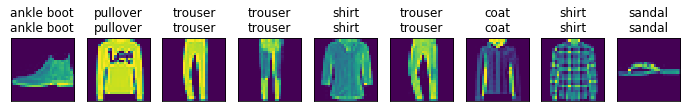

In [35]:
X, y = iter(test_iter).next()

true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(tf.argmax(net(X), axis=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

show_fashion_mnist(X[0:9], titles[0:9])

## softmax的简洁实现

In [1]:
import tensorflow as tf
from tensorflow import keras

### 初始化参数和获取数据

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [6]:
# 归一化数据
x_train = x_train / 255.0
x_test = x_test / 255.0

In [4]:
# 6000 * 10 * 28 * 28
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

### 定义网络模型

In [7]:
# 第一层是Flatten，将28 * 28的像素值，压缩成一行 (784, ) 第二层还是Dense，因为是多分类问题，激活函数使用softmax
net = keras.Sequential([keras.layers.Flatten(input_shape=(28, 28)), 
                         keras.layers.Dense(10, activation=tf.nn.softmax)])

In [8]:
help(keras.layers.Flatten)

Help on class Flatten in module tensorflow.python.keras.layers.core:

class Flatten(tensorflow.python.keras.engine.base_layer.Layer)
 |  Flattens the input. Does not affect the batch size.
 |  
 |  If inputs are shaped `(batch,)` without a channel dimension, then flattening
 |  adds an extra channel dimension and output shapes are `(batch, 1)`.
 |  
 |  Arguments:
 |    data_format: A string,
 |      one of `channels_last` (default) or `channels_first`.
 |      The ordering of the dimensions in the inputs.
 |      `channels_last` corresponds to inputs with shape
 |      `(batch, ..., channels)` while `channels_first` corresponds to
 |      inputs with shape `(batch, channels, ...)`.
 |      It defaults to the `image_data_format` value found in your
 |      Keras config file at `~/.keras/keras.json`.
 |      If you never set it, then it will be "channels_last".
 |  
 |  Example:
 |  
 |  ```python
 |  model = Sequential()
 |  model.add(Convolution2D(64, 3, 3,
 |                         

### 定义损失函数

In [9]:
loss = 'sparse_categorical_crossentropy'

In [10]:
from tensorflow import losses

In [11]:
# SparseCategoricalCrossentropy 已经除以了 batch_size,所以sgd 不需要再除以 batch_size 了
# 默认，SUM_OVER_BATCH_SIZE，Scalar SUM divided by number of elements in losses. 
# https://stackoverflow.com/questions/58159154/how-to-calculate-categorical-cross-entropy-by-hand
cross_entropy = losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

In [98]:
help(losses.SparseCategoricalCrossentropy)

Help on class SparseCategoricalCrossentropy in module tensorflow.python.keras.losses:

class SparseCategoricalCrossentropy(LossFunctionWrapper)
 |  Computes the crossentropy loss between the labels and predictions.
 |  
 |  Use this crossentropy loss function when there are two or more label classes.
 |  We expect labels to be provided as integers. If you want to provide labels
 |  using `one-hot` representation, please use `CategoricalCrossentropy` loss.
 |  There should be `# classes` floating point values per feature for `y_pred`
 |  and a single floating point value per feature for `y_true`.
 |  
 |  In the snippet below, there is a single floating point value per example for
 |  `y_true` and `# classes` floating pointing values per example for `y_pred`.
 |  The shape of `y_true` is `[batch_size]` and the shape of `y_pred` is
 |  `[batch_size, num_classes]`.
 |  
 |  Usage:
 |  
 |  ```python
 |  cce = tf.keras.losses.SparseCategoricalCrossentropy()
 |  loss = cce(
 |    tf.convert

### 定义优化函数

In [12]:
optimizer = tf.keras.optimizers.SGD(0.1)

### 训练

方式一，tf compile api

In [8]:
net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
net.fit(x_train, y_train, epochs=5, batch_size=256)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 1s 19us/sample - loss: 0.7979 - accuracy: 0.7376
Epoch 2/5
60000/60000 [==============================] - 0s 5us/sample - loss: 0.5765 - accuracy: 0.8090
Epoch 3/5
60000/60000 [==============================] - 0s 6us/sample - loss: 0.5294 - accuracy: 0.8236
Epoch 4/5
60000/60000 [==============================] - 0s 6us/sample - loss: 0.5041 - accuracy: 0.8312
Epoch 5/5
60000/60000 [==============================] - 0s 5us/sample - loss: 0.4881 - accuracy: 0.8352


In [10]:
test_loss, test_acc = net.evaluate(x_test, y_test)
print('Test Acc:',test_acc)

10000/10000 [==============================] - 0s 20us/sample - loss: 0.5268 - accuracy: 0.8147
Test Acc: 0.8147


方式二

In [13]:
# 迭代周期，学习率
num_epochs, lr = 5, 0.1
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, trainer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                y_hat = net(X, training=True)
                print(y_hat.dtype, y_hat.shape, y.dtype,y.shape)
                l = loss(y, y_hat)
                #print(params)
                grads = tape.gradient(l, net.trainable_variables)
                # tf.keras.optimizers.SGD 直接使用是随机梯度下降 theta(t+1) = theta(t) - learning_rate * gradient
                trainer.apply_gradients(zip(grads, net.trainable_variables))  
                
            train_l_sum += l.numpy()
            train_acc_sum += tf.reduce_sum(tf.cast(tf.argmax(y_hat, axis=1) == tf.cast(y, dtype=tf.int64), dtype=tf.int64)).numpy()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'% (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

trainer = tf.keras.optimizers.SGD(lr)
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, lr=lr, trainer=trainer)

<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> 

<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> (256,)
<dtype: 'float32'> (256, 10) <dtype: 'uint8'> 

NameError: name 'evaluate_accuracy' is not defined